In [1]:
# uncomment this to use CPU instead of GPU
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Variational Convolutional Autoencoder

Some references:
- https://arxiv.org/pdf/1606.05908.pdf
- https://www.youtube.com/watch?v=Tc-XfiDPLf4
- https://towardsdatascience.com/variational-inference-derivation-of-the-variational-autoencoder-vae-loss-function-a-true-story-3543a3dc67ee

In [2]:
import tensorflow as tf
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
import requests
import pandas as pd
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.manifold import TSNE
from functools import reduce
from tensorflow import keras as keras
from matplotlib import gridspec


In [3]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping

In [4]:
from tensorflow.keras.datasets import mnist

### Load MNIST dataset

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


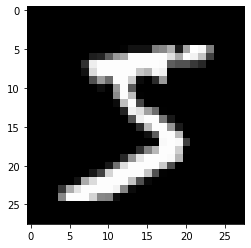

In [7]:
plt.figure()
plt.imshow(x_train[0, :, :, 0], cmap='gray')

#### reparameterization trick
instead of sampling from $Q(z|X)$, sample $\epsilon = N(0,I)$

This reparametrizatoin trick allows to backpropagate.

`z = z_mean + sqrt(var) * epsilon`


In [8]:
from tensorflow.keras import backend as K
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [9]:
batch_size = 100
img_width = x_train.shape[1]
img_height = x_train.shape[2]
channels = x_train.shape[3] # images are in black and white, for RGB we have 3 channels (r,g,b)

### Variational Convolutional Autoencoder architecture

In [38]:
latent_dim = 2
conv_shape = (3, 3)

Encoder

In [39]:
input_img = Input(shape=(img_width, img_height, channels))
x = Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu')(input_img)
x = Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu')(x)
x = Flatten()(x)
x = Dense(50, activation='relu')(x)
x = Dense(50, activation='relu')(x)
x = Dense(2 * latent_dim)(x)
x_split = tf.split(x, num_or_size_splits=2, axis=1, name='split')
z = Lambda(sampling, output_shape=(latent_dim,), name='z')(x_split)

#### decoder

In [40]:
input_gen = Input(shape=(latent_dim,))
y = Dense(50, activation='relu')(input_gen)
x = Dense(50, activation='relu')(x)
y = Dense(units=32*7*7, activation='relu')(input_gen)
y = keras.layers.Reshape((7,7,32))(y)
y = keras.layers.Conv2DTranspose(
    filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu')(y)
y = keras.layers.Conv2DTranspose(
    filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu')(y)
y = keras.layers.Conv2DTranspose(
    filters=1, kernel_size=3, strides=(1, 1), padding="SAME")(y)

In [42]:
encoder = Model(input_img, [x_split[0], x_split[1], z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 13, 13, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 6, 6, 64)     18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 2304)         0           conv2d_3[0][0]                   
____________________________________________________________________________________________

In [43]:
decoder = Model(input_gen, y)
decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1568)              4704      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 41,953
Trainable params: 41,953
Non-trainable params: 0
_______________________________________________________

In [44]:
output = decoder(encoder(input_img)[2])
vae = Model(input_img, output)
vae.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 136820    
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         41953     
Total params: 178,773
Trainable params: 178,773
Non-trainable params: 0
_________________________________________________________________


#### generate loss
some references:
- https://keras.io/examples/variational_autoencoder/
- https://arxiv.org/pdf/1312.6114.pdf

In [45]:
reconstruction_loss = keras.losses.mse(keras.layers.Flatten()(input_img), keras.layers.Flatten()(output))
reconstruction_loss *= 28*28

kl_loss = 1 + x_split[1] - K.square(x_split[0]) - K.exp(x_split[1])
kl_loss = K.sum(kl_loss, axis=1)
kl_loss = -0.5 * kl_loss
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

vae.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 136820      input_3[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 28, 28, 1)    41953       encoder[1][2]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 13, 13, 32)   320         input_3[0][0]                    
____________________________________________________________________________________________

In [46]:
log_dir = "./logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_cb = TensorBoard(
    log_dir=log_dir, 
    profile_batch=0)

es_cb = EarlyStopping(
    monitor='val_loss',
    verbose=True,
    patience=12,
    min_delta=0.0001, 
    restore_best_weights=True)

lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    verbose=True,
    patience=8,
    mi_delta=0.0001)

cb = [tb_cb, es_cb, lr_cb]

In [47]:
epochs = 200

autoencoder_train = vae.fit(
    x=x_train, 
    batch_size=batch_size,
    epochs=epochs, 
    shuffle=True,
    validation_data=(x_test, None),
    callbacks=cb)

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 5s 76us/sample - loss: 46.5371 - val_loss: 41.7288
Epoch 2/200
60000/60000 [==============================] - 4s 60us/sample - loss: 40.8513 - val_loss: 39.9359
Epoch 3/200
60000/60000 [==============================] - 4s 61us/sample - loss: 39.4244 - val_loss: 39.3357
Epoch 4/200
60000/60000 [==============================] - 4s 60us/sample - loss: 38.5878 - val_loss: 38.1143
Epoch 5/200
60000/60000 [==============================] - 4s 60us/sample - loss: 38.0463 - val_loss: 37.8039
Epoch 6/200
60000/60000 [==============================] - 4s 60us/sample - loss: 37.6660 - val_loss: 37.8224
Epoch 7/200
60000/60000 [==============================] - 4s 61us/sample - loss: 37.4424 - val_loss: 37.1660
Epoch 8/200
60000/60000 [==============================] - 4s 60us/sample - loss: 37.1695 - val_loss: 37.3756
Epoch 9/200
60000/60000 [==============================] - 4s 60us/sam

60000/60000 [==============================] - 4s 60us/sample - loss: 33.9371 - val_loss: 34.3240
Epoch 74/200
60000/60000 [==============================] - 4s 60us/sample - loss: 33.8216 - val_loss: 34.3418
Epoch 75/200
60000/60000 [==============================] - 4s 61us/sample - loss: 33.8003 - val_loss: 34.2947
Epoch 76/200
60000/60000 [==============================] - 4s 60us/sample - loss: 33.7551 - val_loss: 34.2554
Epoch 77/200
60000/60000 [==============================] - 4s 60us/sample - loss: 33.7410 - val_loss: 34.2086
Epoch 78/200
60000/60000 [==============================] - 4s 60us/sample - loss: 33.7278 - val_loss: 34.2536
Epoch 79/200
60000/60000 [==============================] - 4s 60us/sample - loss: 33.6958 - val_loss: 34.3021
Epoch 80/200
60000/60000 [==============================] - 4s 60us/sample - loss: 33.6723 - val_loss: 34.2507
Epoch 81/200
60000/60000 [==============================] - 4s 60us/sample - loss: 33.6509 - val_loss: 34.1711
Epoch 82/200
6

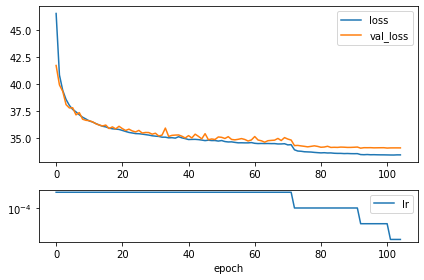

In [48]:
plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax1 = plt.subplot(gs[0])
plt.plot(autoencoder_train.history['loss'], label='loss')
plt.plot(autoencoder_train.history['val_loss'], label='val_loss')
plt.legend()
ax2 = plt.subplot(gs[1])
plt.plot(autoencoder_train.history['lr'], label='lr')
plt.legend()
ax2.set_xlabel('epoch')
ax2.set_yscale('log')
plt.tight_layout()

In [49]:
saved = False
if not saved:
    vae.save('./vae_keras_model_{}_{}.hdf5'.format(latent_dim, epochs))
    encoder.save('./vae_encoder_keras_model_{}_{}.hdf5'.format(latent_dim, epochs))
    decoder.save('./vae_decoder_keras_model_{}_{}.hdf5'.format(latent_dim, epochs))    
    saved = True



### load model

In [50]:
# loaded_model = tf.keras.models.load_model('./vae_model_100.hdf5')

In [51]:
# loaded_model.layers

### Visualization of the latent space
The mean and the variance distributions may have a defined structure in the latent space, but $z$ in principle has a multidimensional unit normal distribution.

In [52]:
import seaborn as sns
from sklearn.metrics import silhouette_score

In [53]:
latents = encoder.predict(x_test)
latent_mu, latent_var, latent_z = latents[0], latents[1], latents[2]

In [56]:
latents_tsnes = {}
for data, which in zip(latents, ['mu', 'var', 'z']):
    if latent_dim==2:
        latent_tsne = data
    else:
        latent_tsne = sklearn.manifold.TSNE(n_components=2, random_state=2).fit_transform(data)
    latent_df = pd.DataFrame({
            'x': latent_tsne[:, 0],
            'y': latent_tsne[:, 1],
            'label': y_test})
    latents_tsnes[which] = latent_df

score: 0.12291668355464935
score: -0.1477169245481491
score: 0.1176840215921402


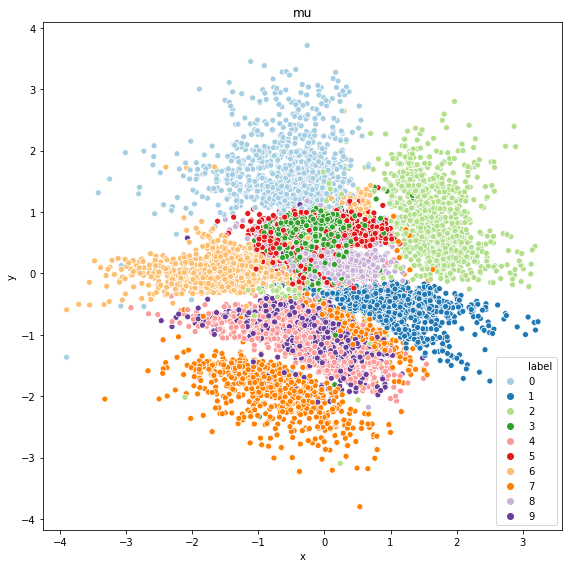

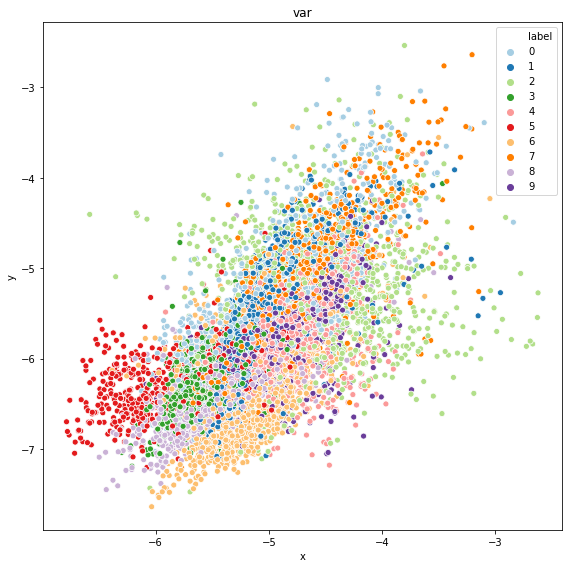

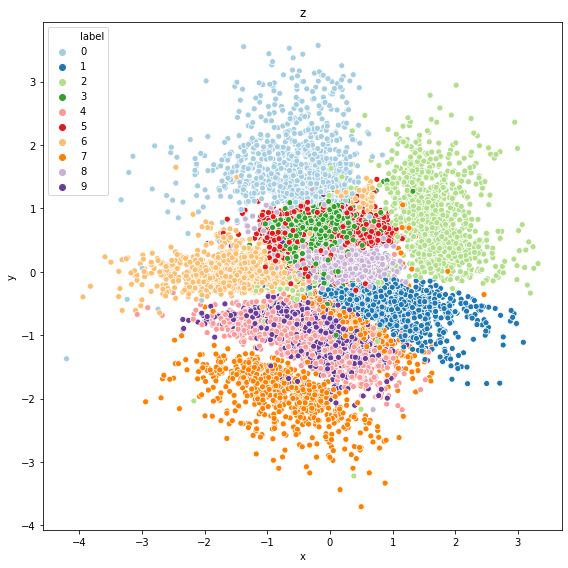

In [57]:
for which in ['mu', 'var', 'z']:
    latent_data = latents_tsnes[which]
    print('score: {}'.format(silhouette_score(latent_data[['x', 'y']].values, latent_data['label'].values )))
    fig = plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(x='x', y='y', hue='label', data=latent_data, palette='Paired')
    ax.set_title(which)
    plt.tight_layout()

#### Generate samples

Differently to a traditional autoencoder, where some points of the latent do not represent do not generate meaningful results, all the latent space of the variational autoencoder should generate meaningful results.

Additionally we force the latent space to be a $\mathcal{N}(0,1$}, so if we draw samples from this distribution and we use them to as the input of the decoder, the decoder should generate meaningful outputs.

In [58]:
n_examples = 16

In [59]:
examples = tf.random.normal(shape=[n_examples, latent_dim])

In [60]:
generated = decoder.predict(examples)

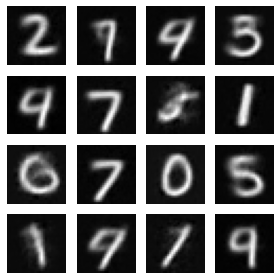

In [63]:
plt.figure(figsize=(4,4))
for i, gen in enumerate(generated):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(gen[:,:,0], cmap='gray')
    ax.axis('off')
    plt.tight_layout()

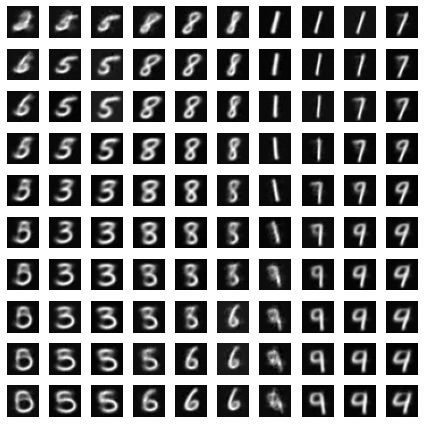

In [84]:
count = 0
fs = 10
itv = np.linspace(1, -1, fs)
plt.figure(figsize=(6,6))
for x_v in itv:
    for y_v in itv:
        xy_v = [[x_v, y_v]]
        gen = decoder.predict(xy_v)
        ax = plt.subplot(fs, fs, count+1)
        plt.imshow(gen[0,:,:,0], cmap='gray')
        ax.axis('off')
        count += 1
plt.tight_layout()        